In [2]:
# pip install vaderSentiment
# !pip install -U textblob
# !pip install --user flair

  Using cached https://files.pythonhosted.org/packages/f2/f0/cec1558fde816e3125e3c617ecf26ec10ef1a598acb02e4975aaa25fc370/flair-0.10-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/80/7c0cad11bd99985cfe7c09427ee0b4f9bd6b048bd13d4ffb32c6db237dfb/tabulate-0.8.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ef/3d/289963bbf51f8d00cdf7483cdc2baee25ba877e8b4eb72157c47211e3b57/Wikipedia-API-0.5.4.tar.gz
     |████████████████████████████████| 1.1MB 1.7MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/5c/2d/b1d99e9ad157dd7de9cd0d36a8a5876b13b55e4b75f7498bc96035fb4e96/sqlitedict-1.7.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/51/6a/c3a0408646408f7283b7bc550c30a32cc791181ec4618592eec13e066ce3/Deprecated-1.2.13-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/70/48a0bd55f79c328504fe6fe7ae8ff651f77a2aadbb1911701385d9bb5ca3/konoha-4.6.5-py3-none-any.whl
  Using cached https:/

## Loading Libraries

In [5]:
import pandas as pd
import numpy as np
import datetime
from textblob import TextBlob, Word, Blobber
import glob
import flair
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Match Data

In [6]:
match_data = pd.read_excel("../data/ManUtd Matches.xlsx")

In [7]:
match_data

,Opponent,Date,Outcome,Score
0,Leeds United,2021-08-14,Won,5-1
1,Southampton,2021-08-22,Draw,1-1
2,Wolves,2021-08-29,Won,1-0
3,Newcastle United,2021-09-11,Won,4-1
4,Young Boys,2021-09-14,Won,1-0
5,West Ham,2021-09-19,Won,2-1
6,West Ham,2021-09-22,Lost,0-1
7,Aston Villa,2021-09-25,Lost,0-1
8,Villareal,2021-09-29,Won,2-1
9,Everton,2021-10-02,Draw,1-1


## Analysing Sentiments of Official Twitter Accounts

In [8]:
def getMatchSentiments(file):
    dataset = pd.read_csv(file)
    dataset = dataset.drop(columns = ["Unnamed: 0"])
    analyzer = SentimentIntensityAnalyzer()
    dataset["sentiment_compound_score"] = dataset["Text"].apply(lambda x : analyzer.polarity_scores(str(x)))
    df = pd.json_normalize(dataset['sentiment_compound_score'])
    dataset_updated = pd.merge(dataset, df, how="inner", right_index = True, left_index= True)
    dataset_updated["sentiment"] = dataset_updated["compound"].apply(lambda x : "Positive" if (x > 0.05) else ("Neutral" if (x > -0.05 and x < 0.05) else "Negative"))
    display(dataset_updated.head(2))
    value_counts = dataset_updated["sentiment"].value_counts().to_frame().T
    return value_counts

In [9]:
def getMatchSentimentsUsingTextBlob(file):
    dataset = pd.read_csv(file)
    dataset = dataset.drop(columns = ["Unnamed: 0"])
    dataset["sentiment_score"] = dataset["Text"].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
    dataset["sentiment"] = dataset["sentiment_score"].apply(lambda x : "Positive" if (x>0) else ("Neutral" if (x==0) else "Negative"))
    display(dataset)
    value_counts = dataset["sentiment"].value_counts().to_frame().T
    return value_counts

In [10]:
def getMatchSentimentsUsingFlair(file):
    dataset = pd.read_csv(file)
    dataset = dataset.drop(columns = ["Unnamed: 0"])
    flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
    sentiments = []
    labels = []
    for i, row in dataset.iterrows():
        sentence = flair.data.Sentence(str(row["Text"]))
        flair_sentiment.predict(sentence)
        value = sentence.labels[0].to_dict()['value'] 
        if value == 'POSITIVE':
            labels.append(value)
            result = sentence.to_dict()['labels'][0]['confidence']
            sentiments.append(result)
        else:
            labels.append(value)
            result = -(sentence.to_dict()['labels'][0]['confidence'])
            sentiments.append(result)
#         dataset["sentiment_score"] = 
    dataset["sentiment_score"] = sentiments
    dataset["sentiment"] = labels
    print(dataset)
#     dataset["sentiment"] = dataset["sentiment_score"].apply(lambda x : "Positive" if (x>0) else ("Neutral" if (x==0) else "Negative"))
#     display(dataset)
    value_counts = dataset["sentiment"].value_counts().to_frame().T
    return value_counts

In [18]:
files = []
for file in glob.glob("../data/Fan Tweets/*"):
    file=file.replace("\\","/")
    files.append(file)

In [22]:
match_sentiments = pd.DataFrame(columns = ["Date", "Outcome", "Positive", "Negative"])
for file in files:
    match_date = datetime.datetime.strptime(file.split("/")[3].split(".")[0]+" 2021", '%d-%b %Y')
    print("Reading Match Sentiments for - ", match_date)
    value_counts = getMatchSentimentsUsingFlair(file)
    match_data["Date"] = match_data["Date"].apply(lambda x : str(x))
    outcome = match_data[match_data["Date"] == str(match_date)]["Outcome"].values[0]
    display(value_counts)
    display(outcome)
    df = pd.DataFrame([[match_date, outcome, value_counts["POSITIVE"]["sentiment"], value_counts["NEGATIVE"]["sentiment"]]], columns = ["Date", "Outcome", "Positive", "Negative"])
    match_sentiments = match_sentiments.append(df)



Reading Match Sentiments for -  2021-10-24 00:00:00
2021-12-06 17:43:44,163 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-10-24 23:02:21+00:00  1452410162669555719   
1    2021-10-24 23:00:44+00:00  1452409755788582915   
2    2021-10-24 22:50:22+00:00  1452407147183149056   
3    2021-10-24 22:26:59+00:00  1452401259944808455   
4    2021-10-24 22:23:25+00:00  1452400363181576198   
..                         ...                  ...   
580  2021-10-24 11:12:59+00:00  1452231644971249666   
581  2021-10-24 11:09:52+00:00  1452230859730432004   
582  2021-10-24 11:06:08+00:00  1452229919082270721   
583  2021-10-24 11:00:42+00:00  1452228551932059658   
584  2021-10-24 10:51:30+00:00  1452226237707997188   

                                                  Text     Username  \
0    @ThereseUTD It was only banter 🤣🤣🤣🤣 https://t....  TotallyMUFC   
1    @AdamCrafton_ How did he brainwash

,NEGATIVE,POSITIVE
sentiment,350,235


'Lost'

Reading Match Sentiments for -  2021-10-02 00:00:00
2021-12-06 17:44:39,025 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-10-02 23:50:45+00:00  1444449809012768770   
1    2021-10-02 23:47:54+00:00  1444449092617351169   
2    2021-10-02 23:45:40+00:00  1444448529330708485   
3    2021-10-02 23:41:14+00:00  1444447412513345541   
4    2021-10-02 23:39:56+00:00  1444447087052181506   
..                         ...                  ...   
398  2021-10-02 00:02:23+00:00  1444090346107965440   
399  2021-10-02 00:01:53+00:00  1444090223957323776   
400  2021-10-02 00:00:16+00:00  1444089815331479556   
401  2021-10-02 12:11:55+00:00  1444273941447647235   
402  2021-10-02 13:41:22+00:00  1444296452428152836   

                                                  Text     Username  \
0    That @GNev2 needed forced into telling the tru...  TotallyMUFC   
1       @talkSPORT End it now and just 

,NEGATIVE,POSITIVE
sentiment,208,195


'Draw'

Reading Match Sentiments for -  2021-09-25 00:00:00
2021-12-06 17:45:16,194 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-09-25 21:59:43+00:00  1441885151399661572   
1    2021-09-25 21:54:45+00:00  1441883900645711875   
2    2021-09-25 21:53:12+00:00  1441883510873153539   
3    2021-09-25 20:45:12+00:00  1441866397819097093   
4    2021-09-25 20:37:17+00:00  1441864406384717826   
..                         ...                  ...   
408  2021-09-25 22:50:55+00:00  1441898036360204291   
409  2021-09-25 22:02:58+00:00  1441885967103709195   
410  2021-09-25 18:27:07+00:00  1441831646269882373   
411  2021-09-25 13:18:12+00:00  1441753907882037248   
412  2021-09-25 12:18:18+00:00  1441738830927867905   

                                                  Text     Username  \
0    @AlexShawESPN @DomBooth19 Signing players like...  TotallyMUFC   
1    @Malachians So your OK with him cr

,NEGATIVE,POSITIVE
sentiment,236,177


'Lost'

Reading Match Sentiments for -  2021-11-02 00:00:00
2021-12-06 17:45:55,111 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-11-02 22:00:00+00:00  1455655962723946496   
1    2021-11-02 21:58:52+00:00  1455655676240441347   
2    2021-11-02 21:52:36+00:00  1455654097315680261   
3    2021-11-02 21:19:24+00:00  1455645742769508358   
4    2021-11-02 20:58:00+00:00  1455640358273040391   
..                         ...                  ...   
599  2021-11-02 12:58:29+00:00  1455519683621408769   
600  2021-11-02 12:43:55+00:00  1455516017111805955   
601  2021-11-02 12:41:53+00:00  1455515506467872769   
602  2021-11-02 11:59:53+00:00  1455504936410701828   
603  2021-11-02 08:38:43+00:00  1455454310414917634   

                                                  Text     Username  \
0    Scholes: "Quality in the middle of the pitch w...  TotallyMUFC   
1    Full Time: #Atalanta 2 : 2 #MUFC \

,NEGATIVE,POSITIVE
sentiment,335,269


'Draw'

Reading Match Sentiments for -  2021-09-11 00:00:00
2021-12-06 17:46:51,076 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-09-11 23:04:42+00:00  1436828075719897089   
1    2021-09-11 21:30:32+00:00  1436804375767289865   
2    2021-09-11 21:02:53+00:00  1436797418293583874   
3    2021-09-11 21:00:40+00:00  1436796859360718856   
4    2021-09-11 20:44:04+00:00  1436792682026782723   
..                         ...                  ...   
510  2021-09-11 14:01:32+00:00  1436691382618533894   
511  2021-09-11 12:59:46+00:00  1436675836577566720   
512  2021-09-11 12:33:11+00:00  1436669147665117194   
513  2021-09-11 12:18:19+00:00  1436665404907216905   
514  2021-09-11 10:20:44+00:00  1436635813874388993   

                                                  Text   Username  \
0                Goodnight ❤️💤 https://t.co/8QrAxtnTZl  utdreport   
1    Luke Shaw enjoying the #USOpen  @EmmaR

,POSITIVE,NEGATIVE
sentiment,312,203


'Won'

Reading Match Sentiments for -  2021-09-19 00:00:00
2021-12-06 17:47:36,990 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-09-19 20:04:52+00:00  1439681921718554635   
1    2021-09-19 20:03:20+00:00  1439681534320168963   
2    2021-09-19 19:59:37+00:00  1439680600034750465   
3    2021-09-19 19:57:35+00:00  1439680086005977091   
4    2021-09-19 19:55:30+00:00  1439679563974516737   
..                         ...                  ...   
487  2021-09-19 13:34:58+00:00  1439583799172554758   
488  2021-09-19 13:31:03+00:00  1439582811787247621   
489  2021-09-19 13:23:18+00:00  1439580861482024974   
490  2021-09-19 12:09:41+00:00  1439562336008822786   
491  2021-09-19 12:01:01+00:00  1439560157114077188   

                                                  Text     Username  \
0    @MikeOxl62656511 I don't think it matters if h...  TotallyMUFC   
1    @MikeOxl62656511 @D_DeGea How defe

,POSITIVE,NEGATIVE
sentiment,261,231


'Won'

Reading Match Sentiments for -  2021-11-06 00:00:00
2021-12-06 17:48:25,668 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-11-06 23:51:53+00:00  1457133669425074176   
1    2021-11-06 23:41:51+00:00  1457131143220846596   
2    2021-11-06 23:40:45+00:00  1457130867000815623   
3    2021-11-06 23:37:22+00:00  1457130014152007682   
4    2021-11-06 23:34:38+00:00  1457129328949465090   
..                         ...                  ...   
500  2021-11-06 10:33:15+00:00  1456932685226643456   
501  2021-11-06 10:03:55+00:00  1456925304128217089   
502  2021-11-06 10:03:55+00:00  1456925302735740929   
503  2021-11-06 07:51:00+00:00  1456891855472406528   
504  2021-11-06 07:48:50+00:00  1456891309810139144   

                                                  Text     Username  \
0    Playing the UTD way they said \n\nThis is emba...  TotallyMUFC   
1    @Rose57Terry @MUFCScoop But at lea

,NEGATIVE,POSITIVE
sentiment,300,205


'Lost'

Reading Match Sentiments for -  2021-08-22 00:00:00
2021-12-06 17:49:11,882 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-08-22 22:26:55+00:00  1429570808725258255   
1    2021-08-22 22:25:49+00:00  1429570531955781633   
2    2021-08-22 21:49:28+00:00  1429561383377674249   
3    2021-08-22 21:25:46+00:00  1429555418683035648   
4    2021-08-22 20:26:52+00:00  1429540598214692866   
..                         ...                  ...   
585  2021-08-22 13:30:39+00:00  1429435852023898123   
586  2021-08-22 13:29:49+00:00  1429435644741394432   
587  2021-08-22 12:44:36+00:00  1429424262981509120   
588  2021-08-22 11:50:00+00:00  1429410521292357641   
589  2021-08-22 09:02:31+00:00  1429368374795112452   

                                                  Text     Username  \
0    @JLHume @ManUtd The 2nd image clearly shows hi...  TotallyMUFC   
1    @JLHume @ManUtd He got the ball be

,NEGATIVE,POSITIVE
sentiment,331,259


'Draw'

Reading Match Sentiments for -  2021-11-20 00:00:00
2021-12-06 17:50:05,387 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-11-20 23:56:20+00:00  1462208219510710273   
1    2021-11-20 23:49:22+00:00  1462206465213665287   
2    2021-11-20 23:46:19+00:00  1462205697261719554   
3    2021-11-20 23:45:10+00:00  1462205407850545156   
4    2021-11-20 23:43:50+00:00  1462205074256629762   
..                         ...                  ...   
641  2021-11-20 15:15:29+00:00  1462077144239071241   
642  2021-11-20 14:10:35+00:00  1462060807789887488   
643  2021-11-20 14:00:49+00:00  1462058350733103108   
644  2021-11-20 14:00:20+00:00  1462058232327946251   
645  2021-11-20 13:50:11+00:00  1462055676147077126   

                                                  Text     Username  \
0    @Amad07827045 @mufckhan2 If they said that and...  TotallyMUFC   
1    @Amad07827045 @mufckhan2 Actually 

,NEGATIVE,POSITIVE
sentiment,393,253


'Lost'

Reading Match Sentiments for -  2021-08-14 00:00:00
2021-12-06 17:51:07,589 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-08-14 21:42:22+00:00  1426660492307845123   
1    2021-08-14 21:41:10+00:00  1426660192771612679   
2    2021-08-14 21:40:33+00:00  1426660037209071623   
3    2021-08-14 21:40:11+00:00  1426659945890697217   
4    2021-08-14 21:39:22+00:00  1426659738583019522   
..                         ...                  ...   
640  2021-08-14 10:59:10+00:00  1426498628626092032   
641  2021-08-14 10:33:35+00:00  1426492188209340419   
642  2021-08-14 10:30:42+00:00  1426491463496523780   
643  2021-08-14 09:16:41+00:00  1426472836366020608   
644  2021-08-14 07:00:00+00:00  1426438438077804546   

                                                  Text     Username  \
0    @CMagfhloinn @ManUtd @MarcoRedDevil Took over ...  TotallyMUFC   
1    @SebMUFC21 @ManUtd @MarcoRedDevil 

,POSITIVE,NEGATIVE
sentiment,380,265


'Won'

Reading Match Sentiments for -  2021-09-14 00:00:00
2021-12-06 17:52:06,925 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-09-14 22:24:43+00:00  1437905174140489729   
1    2021-09-14 21:29:05+00:00  1437891173289443329   
2    2021-09-14 21:00:40+00:00  1437884022466752530   
3    2021-09-14 20:56:48+00:00  1437883051644755980   
4    2021-09-14 20:42:20+00:00  1437879411244736515   
..                         ...                  ...   
329  2021-09-14 17:14:02+00:00  1437826989252087816   
330  2021-09-14 17:09:29+00:00  1437825846211919873   
331  2021-09-14 16:59:39+00:00  1437823371119677452   
332  2021-09-14 15:49:59+00:00  1437805839746797570   
333  2021-09-14 15:45:57+00:00  1437804824330915849   

                                                  Text     Username  \
0    Excuse after excuse, that is all we get from G...  TotallyMUFC   
1    @HamedTGTBoxing @SageLutchman8 I l

,NEGATIVE,POSITIVE
sentiment,172,162


'Won '

Reading Match Sentiments for -  2021-09-22 00:00:00
2021-12-06 17:52:40,358 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-09-22 21:59:12+00:00  1440797855355060227   
1    2021-09-22 21:37:07+00:00  1440792301333221377   
2    2021-09-22 21:34:50+00:00  1440791725941739521   
3    2021-09-22 21:28:58+00:00  1440790248233979907   
4    2021-09-22 21:26:10+00:00  1440789544811446276   
..                         ...                  ...   
272  2021-09-22 20:45:09+00:00  1440779223455580166   
273  2021-09-22 20:39:05+00:00  1440777695600672772   
274  2021-09-22 20:34:32+00:00  1440776550517854212   
275  2021-09-22 18:55:29+00:00  1440751623920181253   
276  2021-09-22 17:47:35+00:00  1440734535948275717   

                                                  Text     Username  \
0           @mcgro86 @MikeLUHG_18_0 He was on private.  TotallyMUFC   
1    @RonaldoIsMyBoi He done that the s

,NEGATIVE,POSITIVE
sentiment,144,133


'Lost'

Reading Match Sentiments for -  2021-11-28 00:00:00
2021-12-06 17:53:08,060 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-11-28 22:09:27+00:00  1465080425358008323   
1    2021-11-28 20:14:31+00:00  1465051499336278016   
2    2021-11-28 19:33:54+00:00  1465041278949810176   
3    2021-11-28 19:17:20+00:00  1465037110847680517   
4    2021-11-28 19:17:04+00:00  1465037040064602113   
..                         ...                  ...   
369  2021-11-28 15:30:13+00:00  1464979951627771906   
370  2021-11-28 15:25:49+00:00  1464978845275234307   
371  2021-11-28 14:53:23+00:00  1464970683344207873   
372  2021-11-28 11:15:34+00:00  1464915868622667777   
373  2021-11-28 10:58:32+00:00  1464911582190841857   

                                                  Text   Username  \
0    The composure 🥶\n\nvia @ManUtd\n\nhttps://t.co...  utdreport   
1                  @Sanchooo10 @ManUtd Love

,NEGATIVE,POSITIVE
sentiment,193,181


'Draw'

Reading Match Sentiments for -  2021-10-20 00:00:00
2021-12-06 17:53:44,368 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-10-20 22:28:18+00:00  1450952042588086272   
1    2021-10-20 21:43:17+00:00  1450940713479413766   
2    2021-10-20 21:42:22+00:00  1450940479655264257   
3    2021-10-20 21:41:14+00:00  1450940195898003458   
4    2021-10-20 21:32:27+00:00  1450937984711331841   
..                         ...                  ...   
629  2021-10-20 18:58:35+00:00  1450899264796872710   
630  2021-10-20 18:56:28+00:00  1450898731679748100   
631  2021-10-20 18:31:01+00:00  1450892324775645198   
632  2021-10-20 17:47:23+00:00  1450881346562314245   
633  2021-10-20 17:45:38+00:00  1450880905413865473   

                                                  Text     Username  \
0    @IamSr10 I mean it's a lot to put on Instagram...  TotallyMUFC   
1    @kentavuraa Martial has been terri

,NEGATIVE,POSITIVE
sentiment,324,310


'Won'

Reading Match Sentiments for -  2021-10-30 00:00:00
2021-12-06 17:54:45,559 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-10-30 19:22:28+00:00  1454529152682446862   
1    2021-10-30 18:54:12+00:00  1454522039134527499   
2    2021-10-30 18:39:33+00:00  1454518354321068034   
3    2021-10-30 18:34:14+00:00  1454517013423038471   
4    2021-10-30 18:33:11+00:00  1454516748867227657   
..                         ...                  ...   
406  2021-10-30 18:17:26+00:00  1454512786843836424   
407  2021-10-30 18:14:41+00:00  1454512094624235521   
408  2021-10-30 14:59:35+00:00  1454462995996741636   
409  2021-10-30 13:35:05+00:00  1454441729554272266   
410  2021-10-30 09:26:43+00:00  1454379225503436800   

                                                  Text     Username  \
0    @goal Based on that logic he also has the back...  TotallyMUFC   
1    @Dav3woodbridg3 Not happy we still

,NEGATIVE,POSITIVE
sentiment,222,189


'Won'

Reading Match Sentiments for -  2021-09-29 00:00:00
2021-12-06 17:55:25,853 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-09-29 22:45:21+00:00  1443346186665144325   
1    2021-09-29 22:43:55+00:00  1443345827217412099   
2    2021-09-29 22:42:20+00:00  1443345425826820102   
3    2021-09-29 20:54:11+00:00  1443318211806642179   
4    2021-09-29 20:38:34+00:00  1443314278489014275   
..                         ...                  ...   
377  2021-09-29 19:09:01+00:00  1443291745706549254   
378  2021-09-29 19:02:32+00:00  1443290110422929411   
379  2021-09-29 18:59:15+00:00  1443289286963613702   
380  2021-09-29 18:10:11+00:00  1443276940211888129   
381  2021-09-29 18:08:17+00:00  1443276462019260419   

                                                  Text     Username  \
0    @joe9ii I think he needs a run of games, ole h...  TotallyMUFC   
1    @joe9ii Of course, I don't think h

,POSITIVE,NEGATIVE
sentiment,212,170


'Won'

Reading Match Sentiments for -  2021-11-23 00:00:00
2021-12-06 17:56:09,182 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-11-23 21:34:42+00:00  1463259739933089798   
1    2021-11-23 21:32:06+00:00  1463259084455563268   
2    2021-11-23 21:31:27+00:00  1463258923021082633   
3    2021-11-23 23:32:43+00:00  1463289438776311810   
4    2021-11-23 22:14:14+00:00  1463269686246789121   
..                         ...                  ...   
462  2021-11-23 16:35:18+00:00  1463184392621338624   
463  2021-11-23 16:31:27+00:00  1463183423409954818   
464  2021-11-23 16:30:52+00:00  1463183275736842244   
465  2021-11-23 16:30:38+00:00  1463183217712893956   
466  2021-11-23 10:17:55+00:00  1463089420740050951   

                                                  Text     Username  \
0      @ManchSg Sure, but it's still more than Ole won  TotallyMUFC   
1                            @TheFornal

,POSITIVE,NEGATIVE
sentiment,252,215


'Won'

Reading Match Sentiments for -  2021-10-16 00:00:00
2021-12-06 17:56:53,421 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-10-16 23:57:54+00:00  1449525036973428742   
1    2021-10-16 22:42:49+00:00  1449506141336133638   
2    2021-10-16 22:41:37+00:00  1449505842219393024   
3    2021-10-16 19:19:18+00:00  1449454926044803074   
4    2021-10-16 18:34:31+00:00  1449443656960720903   
..                         ...                  ...   
583  2021-10-16 20:06:42+00:00  1449466853215121418   
584  2021-10-16 16:58:40+00:00  1449419535447117830   
585  2021-10-16 14:37:39+00:00  1449384044542758914   
586  2021-10-16 14:14:07+00:00  1449378123221504000   
587  2021-10-16 10:42:39+00:00  1449324907830124544   

                                                  Text     Username  \
0    Wondered why #OleIn was trending \n\nThen seen...  TotallyMUFC   
1           @johnaokane Night mate.\n\n

,NEGATIVE,POSITIVE
sentiment,317,271


'Lost'

Reading Match Sentiments for -  2021-08-29 00:00:00
2021-12-06 17:57:47,810 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                      Datetime             Tweet Id  \
0    2021-08-29 22:03:03+00:00  1432101515834109952   
1    2021-08-29 17:44:36+00:00  1432036474321575940   
2    2021-08-29 17:07:32+00:00  1432027147191865359   
3    2021-08-29 17:06:08+00:00  1432026795457527809   
4    2021-08-29 17:03:43+00:00  1432026186213900291   
..                         ...                  ...   
474  2021-08-29 14:36:39+00:00  1431989176640098309   
475  2021-08-29 14:31:14+00:00  1431987814196031497   
476  2021-08-29 12:41:25+00:00  1431960178895855624   
477  2021-08-29 12:36:55+00:00  1431959046635020288   
478  2021-08-29 12:32:01+00:00  1431957810795925505   

                                                  Text     Username  \
0    @DepotLyr @JoySportsGH Gutted I missed it but ...  TotallyMUFC   
1    @jnrolaolu Tbf having seen it in s

,POSITIVE,NEGATIVE
sentiment,273,206


'Won'

## Visualising Match Sentiments for Official Accounts

In [23]:
match_sentiments.reset_index().drop(columns = ["index"])
match_sentiments["pos_neg_ratio"] = match_sentiments["Positive"]/match_sentiments["Negative"]
match_sentiments = match_sentiments.round({'pos_neg_ratio': 2})
match_sentiments["Outcome"] = match_sentiments["Outcome"].apply(lambda x : x.strip())
# match_sentiments["overall_sentiment"] = match_sentiments["overall_sentiment"].replace(True, "Positive")
# match_sentiments["overall_sentiment"] = match_sentiments["overall_sentiment"].replace(False, "Negative")
match_sentiments

,Date,Outcome,Positive,Negative,pos_neg_ratio
0,2021-10-24,Lost,235,350,0.671429
0,2021-10-02,Draw,195,208,0.9375
0,2021-09-25,Lost,177,236,0.75
0,2021-11-02,Draw,269,335,0.802985
0,2021-09-11,Won,312,203,1.536946
0,2021-09-19,Won,261,231,1.12987
0,2021-11-06,Lost,205,300,0.683333
0,2021-08-22,Draw,259,331,0.782477
0,2021-11-20,Lost,253,393,0.643766
0,2021-08-14,Won,380,265,1.433962


This visualisation shows that regardless of the match outcomes, the sentiment of official accounts remains positive. 

In [24]:
# ax = sns.catplot(x="Date", y="pos_neg_ratio", hue="Outcome", kind="bar", data=match_sentiments, height=10, aspect=1)
x_dates = match_sentiments['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')

This visualisation clearly shows that we have more positive sentiment tweets than negative sentiment tweets in official player and as well as team accounts.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Sentiment Count')

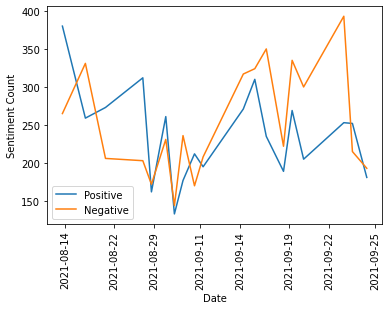

In [25]:
ax = sns.lineplot(x="Date", y="Positive", data = match_sentiments, label="Positive")
ax = sns.lineplot(x="Date", y="Negative", data = match_sentiments, label="Negative")
ax.set_xticklabels(labels=x_dates, rotation=90)
ax.set_ylabel("Sentiment Count")

In [26]:
import pandas as pd
def clean_data(data):
    #convert tweets to lower case
    data['Text'] = data['Text'].str.lower()
    stop = set(stopwords.words('english'))

    #url removes
    data['Text'] = data['Text'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
    data['Text'] = data['Text'].str.replace(r'www\.\S+\.com','')

    #removes retweets & cc
    data['Text'] = data['Text'].str.replace(r'rt|cc', '')

    #hashtags removes
    data['Text'] = data['Text'].str.replace(r'#\S+', '')

    #user mention removes
    data['Text'] = data['Text'].str.replace(r'@\S+', '')

    #emoji 
    data['Text'] = data['Text'].str.replace(r'[^\x00-\x7F]+', '')

    #html tags
    data['Text'] = data['Text'].str.replace(r'<.*?>', '')

    #removes extra spaces
    data['Text'] = data['Text'].str.replace(r' +', ' ')

    #punctuation
    data['Text'] = data['Text'].str.replace('[{}]'.format(string.punctuation), '')

#     #stop words removes
#     data['Text'] = data['Text'].apply(lambda x: [item for item in x if item not in stop])

#     #convert preprocessed list words to string 
#     data['Text'] = data['Text'].apply(' '.join)
    return data


import spacy
import string
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.corpus import stopwords

def pos_tagging(data):
    req_tag = ['NN']
    extracted_words = []
    i = 0
    try:
        for ind, x in data.iterrows():
            doc = nlp(x["Text"])
            for token in doc:
                i += 1
                if token.tag_ in req_tag and token.shape_ != 'x' and token.shape_ != 'xx' and token.shape_ != 'xxx':
                    extracted_words.append(token.lemma_)
        return extracted_words
    except Exception as e:
        print("Exception", e)
        return extracted_words

extracted_words = []
for file in files:
    data = pd.read_csv(file)
    data = clean_data(data)
    extract_words = pos_tagging(data)
    extracted_words.append(extract_words)

extracted_words = [item for t in extracted_words for item in t]
from collections import Counter
word_freq = Counter(extracted_words)
print(word_freq.most_common(10))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_l

[('game', 475), ('team', 340), ('time', 337), ('goal', 328), ('today', 318), ('manager', 273), ('season', 258), ('club', 245), ('league', 238), ('ball', 219)]


In [21]:
### Official -- 
# [('goal', 57), ('trafford', 54), ('time', 33), ('team', 31), ('boss', 30), ('game', 28), ('change', 27), ('today', 23), ('season', 22), ('night', 18)]


### Fan -- 
#